# Code quality of life changes to make:

The `InverseProblem` is not using the `Drone`. It's hanging on to the drone object but is not using it in any meaningful way. This unecessarily obscures the drone away in a way that is confusing. It seems like the only reason this is done is so that the `Drone` can be passed on to another class, `Posterior`, which only uses the drone for it's control derivatives.

The `InverseProblem` class should handle the inverse problem in a more general sense. What is the computational result of solving the inverse problem?

It is very unclear where many of the associated objects are stored in the provided classes.

# From model to utility-function-gradient

In this notebook we follow the path from a user-provided test problem (steady state advection diffusion equation), over how measurements are taken along a path characterized by flight path parameters `alpha`, to the utility function and its gradient. The main purpose of this notebook is to check that
1. after changing the source class structure, everything still works
2. the gradient computation still works after its code is put from its model specific form into the general source code
3. show how to use the main source functions for use in the `Optimization` class

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion_FEniCS")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from MyDrone import MyDrone as Drone
from OEDUtility import OEDUtility

import time
tStart_notebook = time.time()

## User settings

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

## Full-order model setup

First we initialize the full-order model. The model is user-specific, but we have imported it here under the name `FOM` such that we can switch out models easily by changing the import statement only (as long as there are no model-specific settings we also need to make).

In [3]:
tStart = time.time()

fom = FOM(mesh_shape='square')

print("Runtime of this block: {} s".format(time.time()-tStart))

  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
Runtime of this block: 9.570892095565796 s


**Note:** I'm not sure why the initialization of the model is taking so long, it didn't used to. I have to double-check what's happening.

For a given parameter, we can solve the model with a call to `solve`. `solve` is a call any `FullOrderModel` subclass has to have.

In [4]:
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

  *** Warning: Found no facets matching domain for boundary condition.


In contrast, we don't require `FullOrderModel` to have a plot function. However, since it's useful to look at the state and we have a plot function for our example model, it doesn't hurt to take a look:

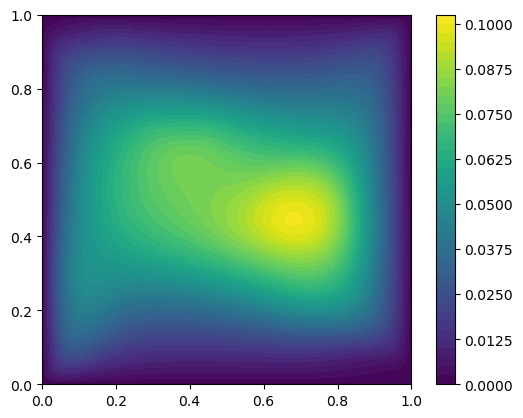

In [5]:
fom.plot(state)

By the way, the output of `fom.solve` is a `State`-object. Using a `State` object makes it easier for us to pass information around. Only the full-order model and the drone need to know how to interact with the state, and all of those are user-defined, so the `State` class makes it easier for the user to keep all the information related to a specific model solve.

**TODO:** One the same note, we should really introduce a `Flightpath` object too to keep track of how `alpha`, its positions, the chosen timediscretization, and the derivatives are connected. 

## Prior

In our discussion we said we wanted the prior to be a part of the `FullOrderModel` class. I'm not entirely sure I like that, I think one could make an argument for keeping it separate, in particular once we go into parameter space reduction. For now it's part of it though, so stop whining.

First, we need to specify the prior. It's assumed to be a Gaussian, which is uniquely specified by its mean and covariance matrix. For our example here we set the prior to be iid, centered around 0.

In [6]:
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)

fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

We can sample the prior by calling `fom.sample`, though for our OED problem we won't need this until we go into parameter space reduction:

In [76]:
fom.sample(n_samples = 2)

array([[ 0.79351099, -1.8052427 ],
       [-0.71449901,  0.36069829],
       [-0.63348447,  0.39488116],
       [-1.19819335,  0.8408732 ],
       [-0.14550379, -0.62491869]])

## Drone

The drone is also user-defined, for two main reasons:
- it needs to interact with the state, which depends on the full-order model, and hence on the FE solver (or whichever discretization is used). We can therefore not specifiy a uniform way to interact with the state
- the parameterization of the flight path is model dependent

Similar to `FOM` above, we have already imported the user-defined version of `Drone`.

In [8]:
drone = Drone(fom, eval_mode = "point-eval")

The argument `eval_mode` is specific to our model problem since we want to compare and test out different ways of measurements. It can be expected that the user only has a single one in mind. For us, the options we had implemented are: "point-eval", "uniform", "gaussian, truncated". However, since I want to get home at some point, I'm only copying over "point-eval" right now, I'll double-check the others another time.

**TODO:** other measurement modes (gaussian, etc.)

The flightpath is parameterized using the "control" `alpha`. For our example here, `alpha = [radius, speed]`. Any `Drone` object has to have the function `get_trajectory` which returns the flight path for a given flight path parameterization.

In [9]:
alpha = np.array([0.25, 0.2])
flightpath, grid_t_drone = drone.get_trajectory(alpha=alpha)

For our case here we can easily plot the flight path:

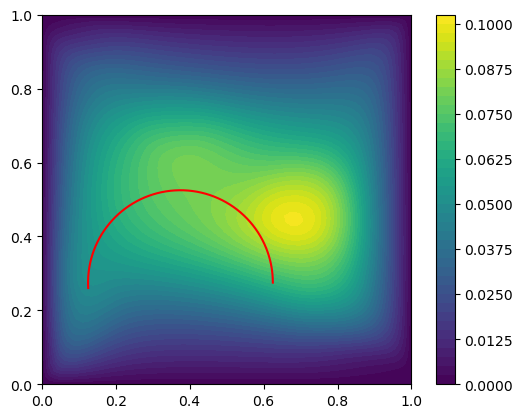

In [10]:
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")

Another function every `Drone` subclass has to have implemented is `measure`:

In [11]:
measurements = drone.measure(state=state, flightpath=flightpath, grid_t=grid_t_drone)

Text(0.5, 1.0, 'point-wise measurement along flightpath')

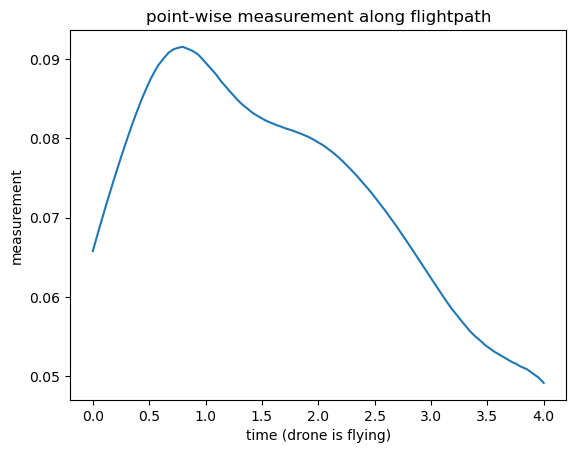

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(grid_t_drone, measurements)
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("point-wise measurement along flightpath")

## Inverse Problem

We now come to the classes that are no longer user-dependent. The first one is `InverseProblem`. It should function regardless of what the forward model is.

`InverseProblem` needs to know the forward model, especially since it contains the prior currently, and the drone. `InverseProblem` is the class that generates the posterior distribution for a given flightpath as one of its outputs, therefore it doesn't get a fixed flight path in its initialization

In [13]:
inversion = InverseProblem(fom, drone)

We precompute the states for a linear combination of parameter basis vectors. For now we use the unit basis, we'll take a closer look at other bases later in the context of parameter space reduction:

In [14]:
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
State solve time (5 parameters): 0.3471834659576416 s


For curiosity and mental health, let's take a look at the states we've gotten for this basis:

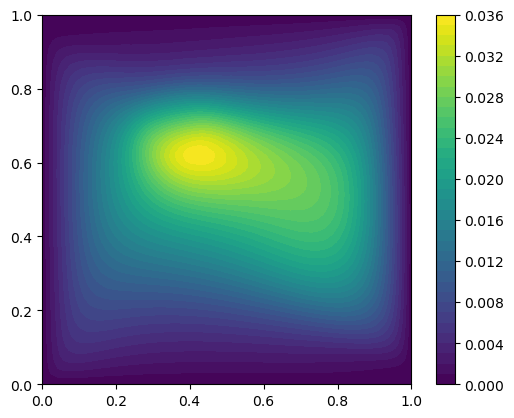

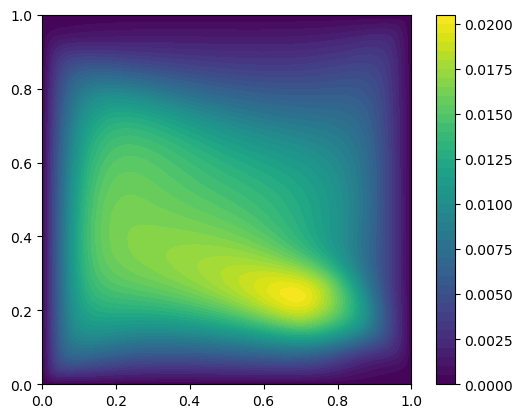

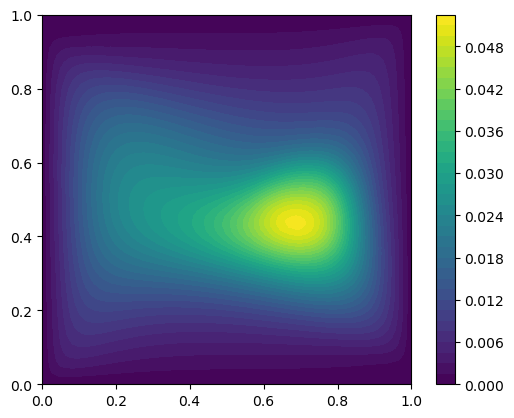

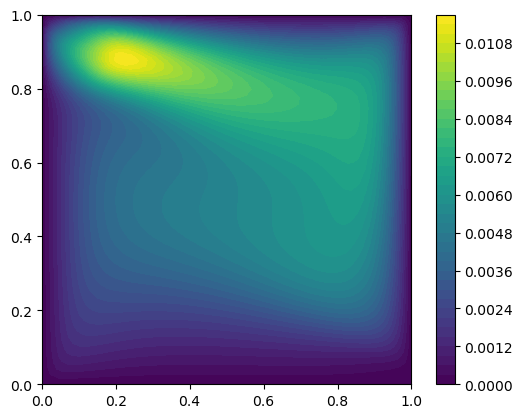

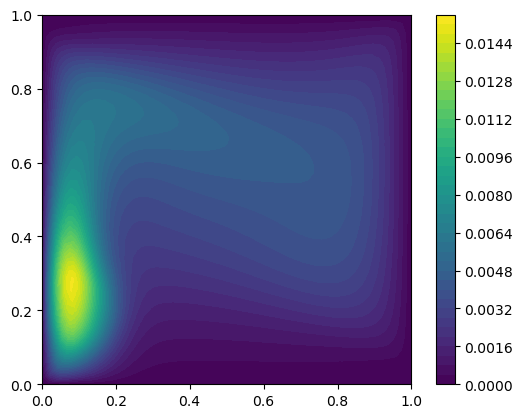

In [15]:
for i in range(5):  # change i = 1, ..., n_para

    fom.plot(inversion.states[i])

Beautiful.

**TODO:** For optimizing the inverse problem, we'll probably want to oursource some computations to, e.g., `hIppylib`. I have not done that yet. 

## Posterior distribution

For a given flight path and measurement data along this path, the `InverseProblem` can generate a posterior distribution for us. For each flightpath, we get a different posterior.

If no measurement data is provided, we can still create an object that handles the "posterior" covariance matrix for us. Note that under our linearity assuptions the posterior covariance matrix is data-independent.

**Note:** `InverseProblem` is potentially a misnomer.

In [16]:
posterior = inversion.compute_posterior(alpha)

If a flightpath was already computed, it should be provides to avoid duplicates and potential changes. The `flightpath` always needs its time discretization (`grid_t_drone` above) in order to be interpreted. So `grid_t` must be passed too in this case.

**Note:** This is an example for why it would make sense to introduce a `Flightpath` class that stores all variables together within one object.

In [17]:
posterior = inversion.compute_posterior(alpha, flightpath=flightpath, grid_t=grid_t_drone)

Let's take a look at the posterior mean. Remember that our prior was centered around 0, and our "true" parameter (the one from which we got the data), has 1's everywhere.

In [18]:
posterior.compute_mean(data=measurements)[0]

array([0.87149589, 0.6650383 , 1.15942905, 0.19466412, 0.22534378])

With more trust in the data (increase `c_scaling` in `InverseProblem`) or less trust in the prior (increase the scaling factor when defining the prior covariance matrix) we see that we indeed converge to the true solution (we didn't apply any noise and have lots of measurements, so that's expected).

We could plot the marginal distribution but for now I think it's ok.

## OED utility function
Time to judge how good our flight path really is. The utility function draws its main information from the inversion.

**TODO:** actually, I don't think `OEDUtility` interacts with anything but the posterior at which it is asked to compute something. I don't think it even needs to be a class but just a collection of functions. I'm keeping it anyway since it makes structural sense and might get more functions in the future.

In [19]:
utility = OEDUtility(inversion)

For any flightpath characterization `alpha`, we can evaluate the utility of its associated flightpath by computing the utility function of the posterior covariance matrix.

**Note:** Again an example in favor of introducing a `Flightpath` class. For a given `alpha` we'd instantiate this class, and if needed it would then compute the posterior for us. The way it's implemented currently we pass the posterior around sepparately from `alpha`, which is just super prone to errors.

In [20]:
alpha = np.array([0.25, 0.2])
posterior = inversion.compute_posterior(alpha)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D"))
print("E-OED:", utility.eval_utility(posterior, mode="E"))

A-OED: 3.971774981178536
D-OED: 0.11561228677087364
E-OED: 0.9999679117870762


For comparison, for the prior we have:

In [21]:
print("A-OED (prior):", np.trace(fom.prior_covar))
print("D-OED (prior):", la.det(fom.prior_covar))
print("E-OED (prior):", np.max(la.eigh(fom.prior_covar)[0]))

A-OED (prior): 5.0
D-OED (prior): 1.0
E-OED (prior): 1.0


To get a feeling for the three functions, let's plot them over our control domain for alpha. First, we need to figure out the admissible domain. We don't want the drone to collide with the boundary of the domain (restriction on the radius). The speed is - theoretically - unrestricted. However, I'm not entirely sure if, when we repeat locations, this would change our noise covariance or if we can just treat them as if there was no overlap. This is only a question for the stationary problem of course.

Until I've figured this out I restrict the maximum speed such that, for minimial radius, the drone will fly at most one circle but not start on a second.

In [22]:
# admissible domain
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
# drone may not collide with buildings or leave the domain

final_time = grid_t_drone[-1]
speed_max = 2 * np.pi * radius_min / final_time
# maximum speed is chosen such that go for at most one circle

Theoretically we could re-visit measurement locations. I need to think about what that means for the noise model though.

Now we compute the OED-utility values for all combinations of radius and speed:

In [23]:
tStart = time.time()

# grid over admissible domain
vec_speed_2d = np.linspace(0.05 * speed_max, speed_max, n_test_2d)
vec_radius_2d = np.linspace(radius_min, radius_max, n_test_2d+1)

vec_speed = np.linspace(0.05 * speed_max, speed_max, n_test)
vec_radius = np.linspace(radius_min, radius_max, n_test+1)
# note: I'm not making the vectors the same lengths so I don't accidentally confuse the directions

# initialize
util = np.zeros((3, n_test_2d+1, n_test_2d))

for i in range(n_test_2d+1):
    for j in range(n_test_2d):
        
        alpha = np.array([vec_radius_2d[i], vec_speed_2d[j]])
        posterior = inversion.compute_posterior(alpha)
        
        util[0, i, j] = utility.eval_utility(posterior, mode="A")
        util[1, i, j] = utility.eval_utility(posterior, mode="D")
        util[2, i, j] = utility.eval_utility(posterior, mode="E")
        
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Runtime of this block:  1.4423264543215433 min.


Finally we can plot the OED-utility. A- and D-OED look fairly similar, E-OED has almost a shock-like behavior. This is because if the drone isn't fast enough for its radius, it will never reach the areas of the state that are influenced by the 5th forcing function. In this case, the uncertainty for the 5th parameter entry will not get reduced, i.e., at least one eigenvalue will remain unchanged when updating the prior. Since the prior was chosen iid., the maximum eigenvalue of the posterior is then the same as the prior. The E-OED utility function will remain constant until the combination of speed and radius is able to detect all forcing functions. At this point the uncertainty in all directions improves and the E-OED utility begins to improve.

Text(0.5, 1.0, 'E-OED')

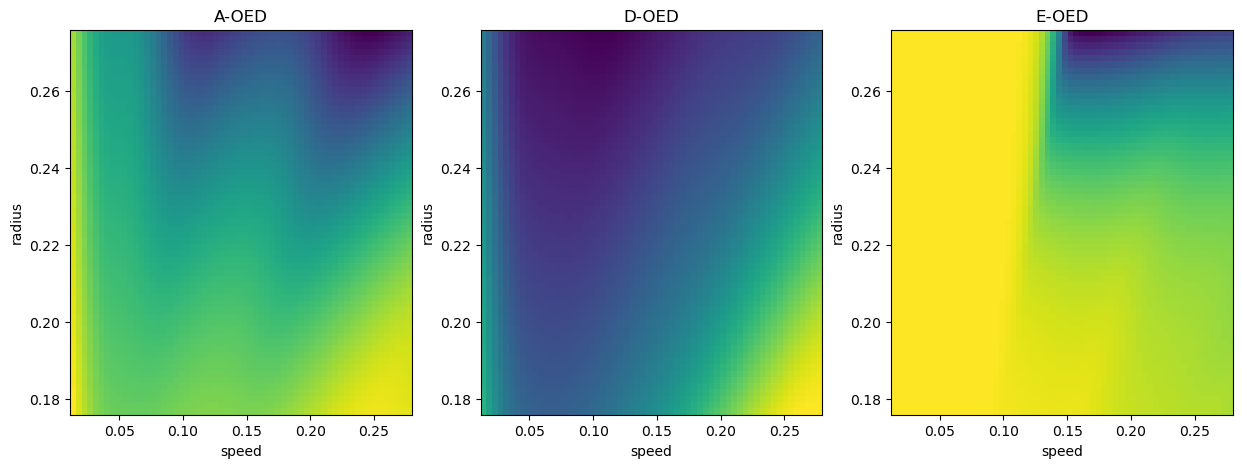

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].pcolormesh(vec_speed_2d, vec_radius_2d, util[i, :, :])
    axs[i].set_xlabel("speed")
    axs[i].set_ylabel("radius")
    
axs[0].set_title("A-OED")
axs[1].set_title("D-OED")
axs[2].set_title("E-OED")

## Derivative of the utility function

### derivative of the position
We take a quick look at the derivatives of the position, because there's an interesting observation to be made (spoiler!). It's also good for double-checking and getting an idea for how the derivatives behave in time.

In [25]:
der_all = drone.d_position_d_control(alpha, flightpath, grid_t_drone)

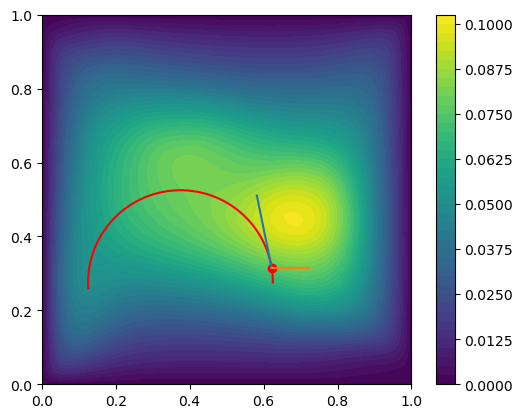

In [26]:
t = 0.2
k = np.argmin(np.abs(grid_t_drone - t))
der = der_all[:, :, k]
pos = flightpath

der_radius = der[0, :]
der_speed = der[1, :]

fom.plot(state)
plt.plot(pos[:, 0], pos[:, 1], color="r")
plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o", color = "r")

plt.plot([pos[k, 0], pos[k, 0] + 1 * der_speed[0]], [pos[k, 1], pos[k, 1] +1 * der_speed[1]])  # speed
plt.plot([pos[k, 0], pos[k, 0] + 0.1 * der_radius[0]], [pos[k, 1], pos[k, 1] + 0.1 * der_radius[1]])  # radius

Both derivatives are nice and interpretable close to `t=0`. The more time passes, the weirder the derivatives look. That's because the more time passes the more influence do the radius and the speed have on the position, and the derivatives can consequently be expected to become larger and larger (If this is not clear, think about the difference quotient). 

This observation might be important for us because since we are planning to puzzle the flightpath together from various curves. It might pose a limit on how long we can make each segment of the control in comparison to the time discretization of the drone. I need to think about this some more.

### Derivatives of the OED-utility function
We've arrived at the final stage - the derivatives of the OED-utility function! We get the derivatives from the `OEDUtility` class with the function `eval_utility`. To specify the position `alpha` at which we want to compute the derivative we pass the associated `Posterior` object. This is not quite intuitive. I think it makes more sense - also for avoiding unnecessary re-computations - to have a `Flightpath` object for each control parameter vector `alpha` that contains the flight path positions, time grid, and any attributes computed along the way like the derivatives. 

Note below that so far we only have the derivatives for A- and D-OED, as well as for "D-inverse" which is the determinant of the inverse posterior covariance matrix (instead of "D", the determinant of the posterior covariance matrix).

Feel free to change the values of `speed_test` and `radius_test` below. They specify where we evaluate the derivative. In addition, we compute the OED-utility function values along `vec_radius x {speed_test}` and `{radius_test} x vec_speed` to visualize whether the derivative is indeed correct.

**Note:**
For the optimization routine, the first part of this block (between `##`) is the most important, since it shows the calls the optimization routine will need to make.

In [27]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref = inversion.compute_posterior(alpha_test)

util_ref = np.zeros(4)
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

der_ref_A = utility.d_utility_d_control(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_control(posterior_ref, mode="D")
der_ref_Dinv = utility.d_utility_d_control(posterior_ref, mode="D-inverse")
## done with the important part

util_test = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Runtime of this block:  0.09797675212224324 min.


First the plot for A-OED:

Text(0.5, 0, 'speed')

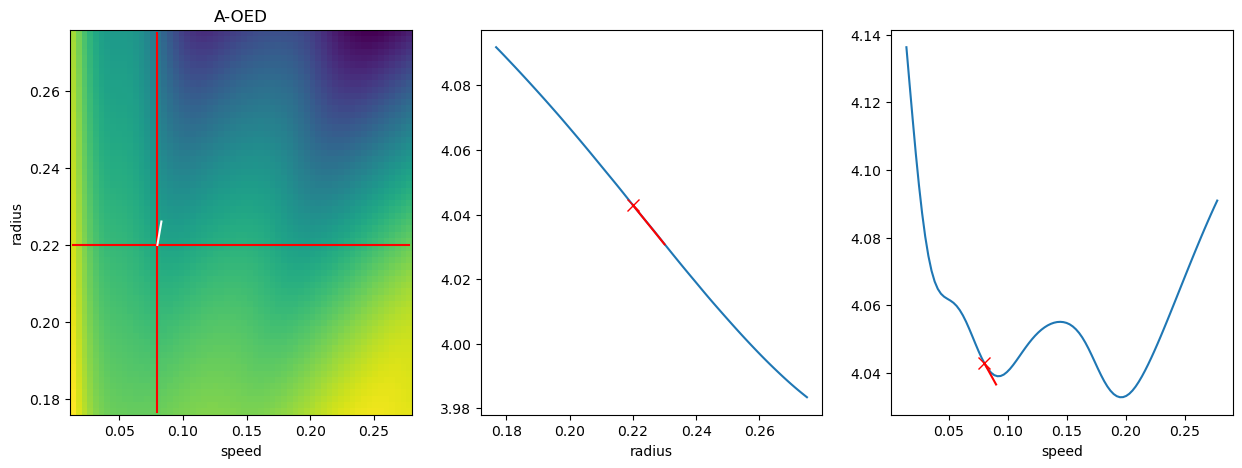

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_A)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[0, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_A[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_A[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("A-OED")

axs[1].plot(vec_radius, util_test[0, 1, :])
axs[1].plot([radius_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[0, 0, :-1])
axs[2].plot([speed_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

In the plot on the left, the sign for the gradient is chosen such that it points into the steepest decent direction.

Here's the plot for D-OED:

Text(0.5, 0, 'speed')

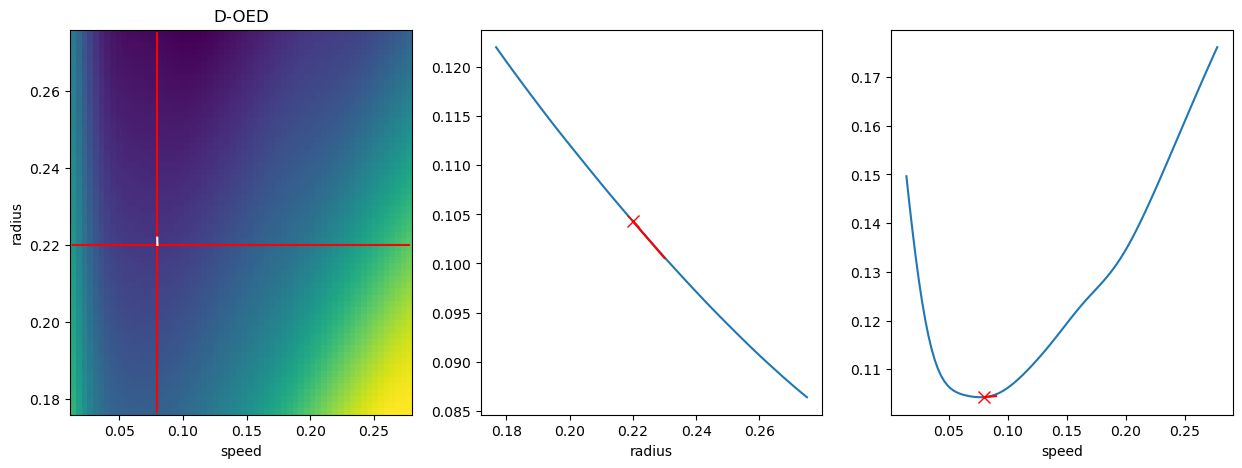

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_D[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_D[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED")

axs[1].plot(vec_radius, util_test[1, 1, :])
axs[1].plot([radius_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[1, 0, :-1])
axs[2].plot([speed_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Instead of minimizing the D-OED criterion, we've also talked about maximizing its inverse, which can be computed more efficiently. In this case the sign for the derivative in the 2D plot was chosen to point into the steepest ascend direction.

Text(0.5, 0, 'speed')

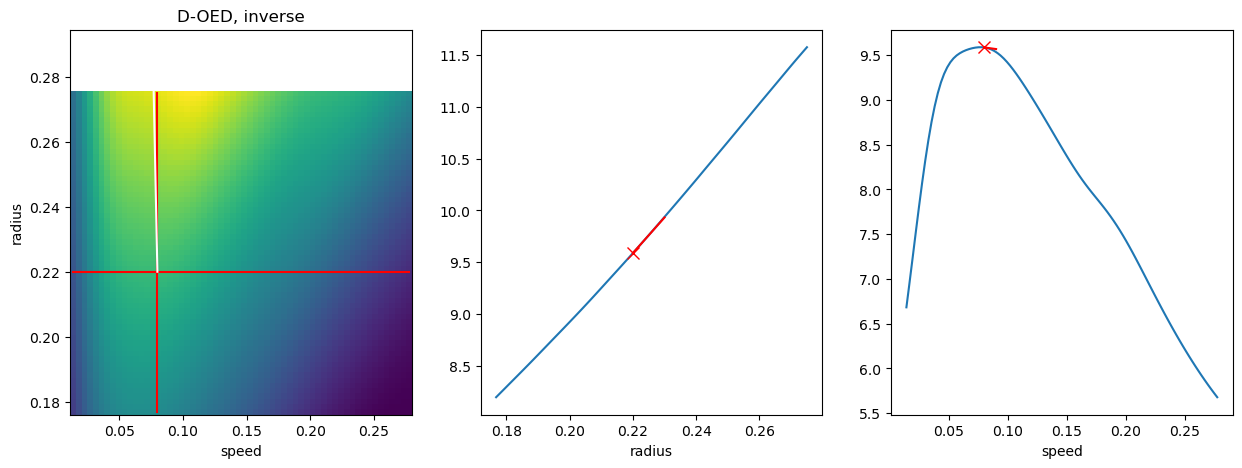

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, 1/util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test + 0.2 * scale * der_ref_Dinv[1]], 
            [radius_test, radius_test + 0.2 * scale * der_ref_Dinv[0]], 
            color = "w", marker = None)
# positive gradient direction because we want to maximize

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED, inverse")

axs[1].plot(vec_radius, util_test[2, 1, :])
axs[1].plot([radius_test], util_ref[2], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[2, 0, :-1])
axs[2].plot([speed_test], util_ref[2], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

## What's there:
- setup of the posterior
- utility function evaluation
- utility function derivatives for point-wise measurements (A, D, D-inverse OED)

I think this should be enough to get started on the optimization routine.

## What's missing?

- class `Flightpath` to keep all computed values for a given `alpha` together and avoid mix-ups
- E-OED derivative
- still need to copy definition of non-pointwise measurement functions over
- derivatives of convolution type measurements and Weierstrass trick
- parameter space reduction
- optimization of the code (don't use `la.inv`, make sure not to re-compute different values, get rid of some `for`-loops)

## The End.

In [31]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 1.7869467258453369 min


# Drone flightpath

The drone flightpath requires a position at time `t` derived from parameters `alpha`. We also need the derivative of position at time `t` as a function of the parameters.

We may wish to have a path that does not have any velocity that we then add velocity to, i.e., an arc length paramaterization that we add a velocity to (some velocities may be not allowable as they may induce other parameters such as angular velocity that may not be allowable).

The way these paths are currently handled, it may be optimal to simply increase the velocity as much as possible. I don't think we have an control on the precision of the measurments we are taking as a function fo the velocity.

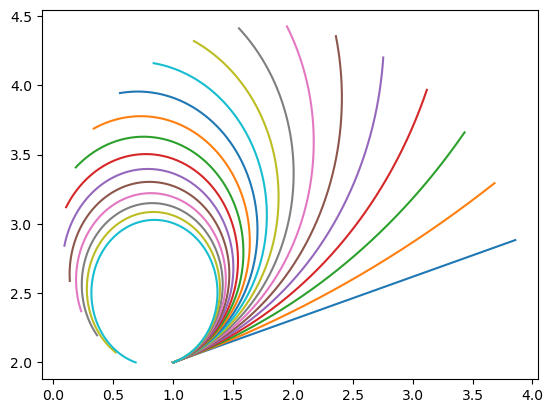

In [32]:
class Path:
    def __init__(self, alpha, initial_time:float = 0.0):
        """
        Path defined by parameters:
        - `"initial x"` : initial position in `x` coordinate
        - `"initial y"` : initial position in `y` coordinate
        - `"initial heading"` : initital heading direction (in radians)
        - `"velocity"` : constant velocity parameter (spatial units per time)
        - `"angular velocity"` : constant angular velocity (radians per time)
        """
        self.alpha = alpha  # Parameters
        if isinstance(alpha, np.ndarray):
            self.alpha = {
                "initial x" : alpha[0],  # initial position vector
                "initial y" : alpha[1],  # initial position vector
                "initial heading" : alpha[2],  # initial heading (radians)
                "velocity" : alpha[3],  # velocity
                "angular velocity" : alpha[4],  # angular velocity
            }
        self.initial_time = initial_time

    def relative_position(self, t):
        raise NotImplementedError
    
    def position(self, t):
        """
        Get the position (x, y) given the parameters and time(s) t
        """
        rel_positions = self.relative_position(t)
        positions = rel_positions + np.array([[self.alpha["initial x"], self.alpha["initial y"]]])

        return positions

    def d_position_d_initial_x(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        
        deriv = np.ones((t.shape[0], 2))
        deriv[:, 1] = 0
        return deriv

    def d_position_d_initial_y(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        
        deriv = np.ones((t.shape[0], 2))
        deriv[:, 0] = 0
        return deriv

    def d_position_d_initial_heading(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        rel_pos = self.relative_position(t)
        deriv = np.empty((t.shape[0], 2))
        deriv[:,0] = -rel_pos[:,1]
        deriv[:,1] =  rel_pos[:,0]
        return deriv
        # deriv = np.empty((t.shape[0], 2))
        # if not self.linear:
        #     deriv[:,0] = self.alpha["velocity"]/self.alpha["angular velocity"] * (
        #         np.cos(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
        #         - np.cos(self.alpha["initial heading"])
        #     )  # this is -pos_y + initial_y
        #     deriv[:,1] = self.alpha["velocity"]/self.alpha["angular velocity"] * (
        #         np.sin(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
        #         - np.sin(self.alpha["initial heading"])
        #     )  # this is pos_x - initial_x
        # else:
        #     deriv[:,0] =-t * self.alpha["velocity"] * np.sin(self.alpha["initial heading"])  # this is -pos_y + initial_y
        #     deriv[:,1] = t * self.alpha["velocity"] * np.cos(self.alpha["initial heading"])  # this is pos_x - initial_x

    def d_position_d_alpha(self, t):
        raise NotImplementedError

    def heading(self, t):
        """
        Heading in radians
        """
        t = t - self.initial_time
        headings = t * self.alpha["angular velocity"] + self.alpha["initial heading"]
        return headings

    def heading_vector(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        headings = self.heading(t)
        return np.hstack((
            np.cos(headings[:,np.newaxis]),
            np.sin(headings[:,np.newaxis])
        ))

class CircularPath(Path):
    """
    Circular arc flight path (if the angular velocity is zero, becomes a linear path)

    Constant velocity and angular velocity
    """
    def __init__(self, alpha, linear_tolerance:float = 1e-14, initial_time:float = 0.0):
        """
        Path defined by parameters:
        - `"initial x"` : initial position in `x` coordinate
        - `"initial y"` : initial position in `y` coordinate
        - `"initial heading"` : initital heading direction (in radians)
        - `"velocity"` : constant velocity parameter (spatial units per time)
        - `"angular velocity"` : constant angular velocity (radians per time)

        Additional parameters can be derived:
        - `"radius"` : the arc radius is equal to the velocity divided by the angular velocity
        """
        super(CircularPath, self).__init__(alpha, initial_time=initial_time)
        self.linear_tolerance = linear_tolerance

        # Induced parameters
        if self.alpha["angular velocity"] != 0:
            self.alpha["radius"] = self.alpha["velocity"]/self.alpha["angular velocity"]
        else:
            self.alpha["radius"] = np.inf

    @property
    def linear(self):
        return np.abs(self.alpha["angular velocity"]) <= self.linear_tolerance

    def relative_position(self, t):
        """
        Get the position (x, y) relative to the initial position (at the initial time)
        given the parameters and time(s) t
        """
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        t = t - self.initial_time

        positions = np.empty((t.shape[0], 2))
        # Currently, numerical problems when angular velocity approaches zero (O(1e-14))
        if not self.linear:
            positions[:,0] = self.alpha["velocity"]/self.alpha["angular velocity"] * (
                np.sin(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
                - np.sin(self.alpha["initial heading"])
            )
            positions[:,1] = self.alpha["velocity"]/self.alpha["angular velocity"] * (
                - np.cos(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
                + np.cos(self.alpha["initial heading"])
            )
        else:  # Linear path
            positions[:,0] = t * self.alpha["velocity"] * np.cos(self.alpha["initial heading"])
            positions[:,1] = t * self.alpha["velocity"] * np.sin(self.alpha["initial heading"])

        return positions
            
    def position(self, t):
        """
        Get the position (x, y) given the parameters and time(s) t
        """

        rel_positions = self.relative_position(t)
        positions = rel_positions + np.array([[self.alpha["initial x"], self.alpha["initial y"]]])

        return positions

    def d_position_d_velocity(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        deriv = self.relative_position(t)/self.alpha["velocity"]
        # deriv = np.empty((t.shape[0], 2))
        # if not self.linear:
        #     deriv[:,0] = 1/self.alpha["angular velocity"] * (
        #         np.sin(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
        #         - np.sin(self.alpha["initial heading"])
        #     )  # this is (pos_x - initial_x)/velocity
        #     deriv[:,1] = 1/self.alpha["angular velocity"] * (
        #         - np.cos(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
        #         + np.cos(self.alpha["initial heading"])
        #     )  # this is (pos_y - initial_y)/velocity
        # else:
        #     deriv[:,0] = t * np.sin(self.alpha["initial heading"])  # this is (pos_x - initial_x)/velocity
        #     deriv[:,1] = t * np.cos(self.alpha["initial heading"])  # this is (pos_y - initial_y)/velocity
        return deriv

    def d_position_d_angular_velocity(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        t = t - self.initial_time

        deriv = np.empty((t.shape[0], 2))

        if not self.linear:
            deriv[:,0] = -self.alpha["velocity"]/self.alpha["angular velocity"]**2 * (
                np.sin(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
                - np.sin(self.alpha["initial heading"])
            ) + self.alpha["velocity"]/self.alpha["angular velocity"] * (
                np.cos(t * self.alpha["angular velocity"] + self.alpha["initial heading"]) * t
            )  # this is rel_pos_x/w + t*(-rel_pos_y + w/v cos(theta_0) )
            
            deriv[:,1] = -self.alpha["velocity"]/self.alpha["angular velocity"]**2 * (
                - np.cos(t * self.alpha["angular velocity"] + self.alpha["initial heading"])
                + np.cos(self.alpha["initial heading"])
            ) + self.alpha["velocity"]/self.alpha["angular velocity"] * (
                np.sin(t * self.alpha["angular velocity"] + self.alpha["initial heading"]) * t
            )  # this is rel_pos_y/w + t*(rel_pos_x + w/v sin(theta_0) )
            
        else:  # Limit as angular velocity goes to zero
            deriv[:,0] = - self.alpha["velocity"]/2 * \
                np.sin(t*self.alpha["angular velocity"] + self.alpha["initial heading"]) * t**2
            deriv[:,1] = self.alpha["velocity"]/2 * \
                np.cos(t*self.alpha["angular velocity"] + self.alpha["initial heading"]) * t**2
        return deriv

    def d_position_d_alpha(self, t):
        derivs = {}
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        derivs["initial x"] = self.d_position_d_initial_x(t)
        derivs["initial y"] = self.d_position_d_initial_y(t)
        
        # alpha[2] is initial heading (radians); can be simplified to a function of position relative to initial position only
        derivs["initial heading"] = self.d_position_d_initial_heading(t)

        # alpha[3] is velocity; can be simplified to a function of position again
        derivs["velocity"] = self.d_position_d_velocity(t)
        
        # alpha[4] is angular veolcity; not as easily simplified
        derivs["angular velocity"] = self.d_position_d_angular_velocity(t)
        
        return derivs
        


alpha = {
    "initial x" : 1.,  # initial position vector
    "initial y" : 2.,  # initial position vector
    "initial heading" : 2.,  # initial heading (radians)
    "velocity" : 1,  # velocity
    "angular velocity" : 2,  # angular velocity
}

plt.figure()
t = np.arange(0, 3, 0.01)
# for av in np.arange(-2, 2, 0.1):
for av in np.arange(0, 2, 0.1):
    alpha = np.array([1., 2., 0.3, 1, av])
    path = CircularPath(alpha)    
    pos = path.position(t)
    plt.plot(pos[:,0], pos[:,1])


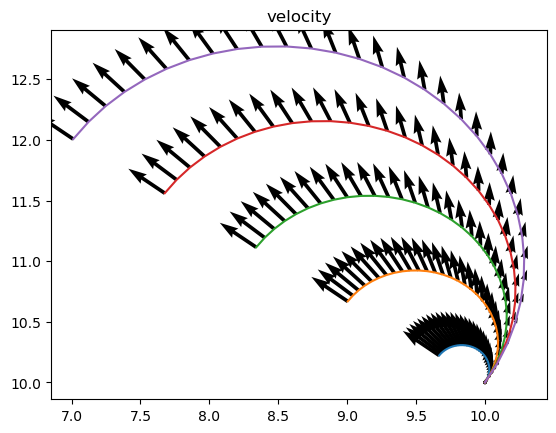

In [33]:
plt.figure()
for v in np.arange(0.1, 1, 0.2):
    t = np.arange(0, 2*np.pi, 0.2)
    
    alpha = np.array([10., 10., 1, v, 0.5])
    path = CircularPath(alpha, initial_time=0)    
    pos = path.position(t)

    derivs = path.d_position_d_alpha(t)
    # keys = ["initial x", "initial y", "initial heading", "velocity", "angular velocity"]
    
    key = "velocity"
    dx = derivs[key][:,0]
    dy = derivs[key][:,1]
    
    plt.plot(pos[:,0], pos[:,1])
    plt.quiver(pos[:,0], pos[:,1], dx, dy)
    plt.title(key)

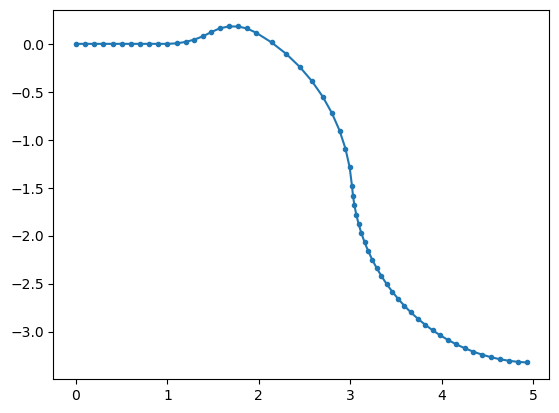

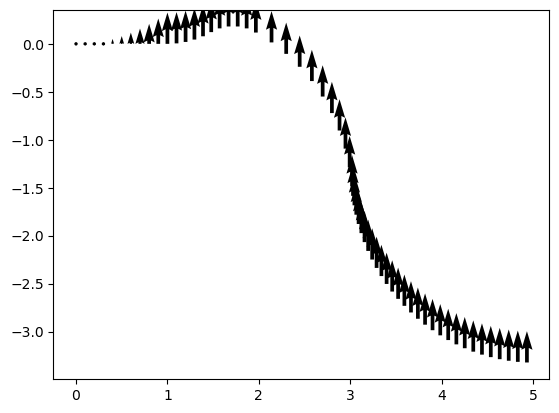

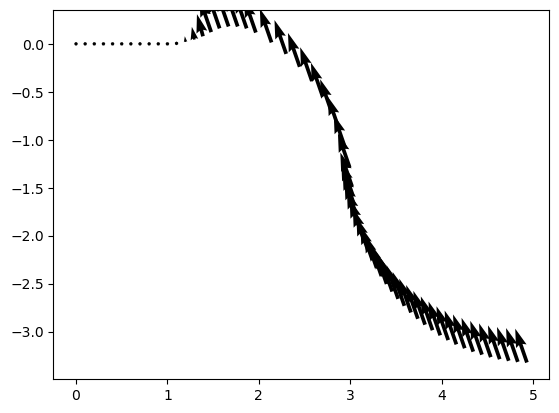

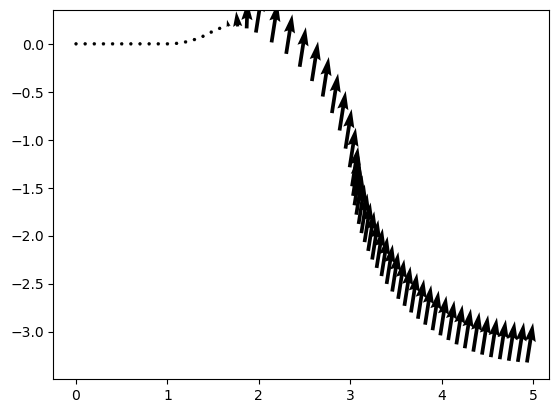

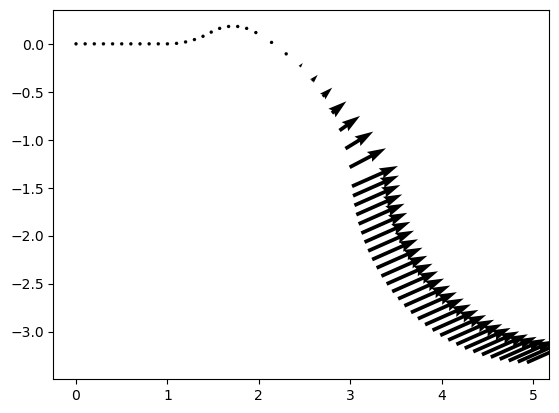

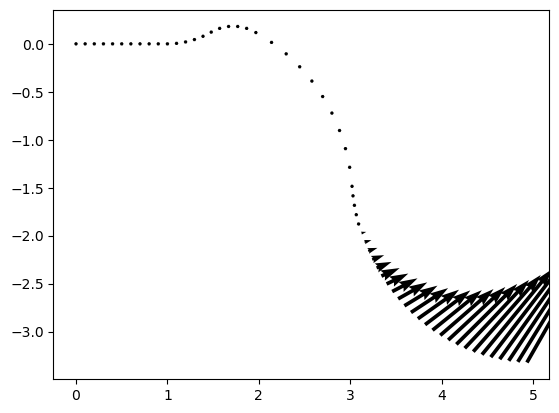

In [34]:
class CombinedCircularPath:
    def __init__(
        self,
        initial_x:float,
        initial_y:float,
        initial_heading:float,
        parameters: list[dict] | np.ndarray,
        transition_times:list | np.ndarray
    ):
        """
        A series of parameters and transition times between switching 
        transition_times begins with an initial time
        """
        self.initial_x = initial_x
        self.initial_y = initial_y
        self.initial_heading = initial_heading
        self.parameters = parameters
        self.transition_times = transition_times
        
        if isinstance(parameters[0], np.ndarray):
            self.paths = [
                CircularPath(np.array([initial_x, initial_y, initial_heading, parameters[0][0], parameters[0][1]]),
                            initial_time = transition_times[0])
            ]
        for (i, params), time in zip(enumerate(parameters[1:]), transition_times[1:]):
            previous_final_position = self.paths[i].position(time)
            previous_final_x, previous_final_y = previous_final_position[0][0], previous_final_position[0][1]
            previous_final_heading = self.paths[i].heading(time)
            self.paths.append(
                CircularPath(np.array([previous_final_x, previous_final_y, previous_final_heading, params[0], params[1]]),
                            initial_time = time)
            )

    
    def position(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        positions = np.empty((t.shape[0], 2))
        positions[:,0] = self.initial_x
        positions[:,1] = self.initial_y
        for (i, start_time), end_time  in zip(enumerate(self.transition_times[:-1]), self.transition_times[1:]):
            indicator  = np.logical_and(t >= start_time, t < end_time)
            positions[indicator] =  self.paths[i].position(t[indicator])
        indicator = t >= self.transition_times[-1]
        positions[indicator] = self.paths[-1].position(t[indicator])
        return positions

    def relative_position(self, t):
        rel_positions = self.position(t)
        rel_positions[:,0] -= self.initial_x
        rel_positions[:,1] -= self.initial_y
        return rel_positions

    def d_position_d_initial_x(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        
        deriv = np.ones((t.shape[0], 2))
        deriv[:, 1] = 0
        return deriv

    def d_position_d_initial_y(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        
        deriv = np.ones((t.shape[0], 2))
        deriv[:, 0] = 0
        return deriv

    def d_position_d_initial_heading(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        rel_pos = self.relative_position(t)
        deriv = np.empty((t.shape[0], 2))
        deriv[:,0] = -rel_pos[:,1]
        deriv[:,1] =  rel_pos[:,0]
        return deriv

    def d_position_d_velocitys(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        
        deriv = np.zeros((t.shape[0], len(self.paths), 2))

        for (i, start_time), end_time  in zip(enumerate(self.transition_times[:-1]), self.transition_times[1:]):
            indicator = np.logical_and(t >= start_time, t < end_time)
            deriv[indicator, i, :] = self.paths[i].d_position_d_velocity(t[indicator])
            deriv[t >= end_time, i, :] = self.paths[i].d_position_d_velocity(end_time)
        
        indicator = t >= self.transition_times[-1]
        deriv[indicator, -1, :] = self.paths[-1].d_position_d_velocity(t[indicator])

        return deriv

    def d_position_d_angular_velocitys(self, t):
        if not isinstance(t, np.ndarray):
            t = np.array([t])

        
        deriv = np.zeros((t.shape[0], len(self.paths), 2))

        for (i, start_time), end_time  in zip(enumerate(self.transition_times[:-1]), self.transition_times[1:]):
            indicator = np.logical_and(t >= start_time, t < end_time)
            deriv[indicator, i, :] = self.paths[i].d_position_d_angular_velocity(t[indicator])
            deriv[t >= end_time, i, :] = self.paths[i].d_position_d_angular_velocity(end_time)
        
        indicator = t >= self.transition_times[-1]
        deriv[indicator, -1, :] = self.paths[-1].d_position_d_angular_velocity(t[indicator])

        return deriv

    def d_position_d_paramters(self, t):
        derivs = {}
        if not isinstance(t, np.ndarray):
            t = np.array([t])
        # alpha[0] is initial x
        derivs["initial x"] = self.d_position_d_initial_x(t)
        
        # alpha[1] is initial y
        derivs["initial y"] = self.d_position_d_initial_y(t)
        derivs["initial heading"] = self.d_position_d_initial_heading(t)

        derivs["velocity"] = self.d_position_d_velocitys(t)
        derivs["angular velocity"] = self.d_position_d_angular_velocitys(t)
        return derivs
        
    
        

path = CombinedCircularPath( 0., 0., 0, np.array([[1, 0], [1, 1], [1, -2], [2, -1], [1, 0.5]]), np.array([0, 1, 1.5, 1.99, 3]))
plt.figure()
t = np.arange(0, 6, 0.1)
pos = path.position(t)
plt.plot(pos[:,0], pos[:,1], '.-')
deriv = path.d_position_d_paramters(t)["angular velocity"]

# plot the boundaries between the segments

deriv.shape
for i in range(deriv.shape[1]):
    plt.figure()
    plt.quiver(pos[:,0], pos[:,1], deriv[:,i, 0], deriv[:,i, 1])


# Derivatives that we need

We need:
- the derivatives of the position as a function of the parameters (see previous)
- the derivatives of the measurement as a function of position (if pointwise, this is simple; if we can transform states such that we can do pointwise measurements, then this is simple; this is simple because this is just the gradient of the state for a pointwise measurement, but we may be able to get away without doing the transform?)
- the derivatives of the optimal experimental design objective

These are all done already (thanks, Nicole!) for a circular path where the parameters are radius and speed.

$$\frac{\partial \Psi(\Sigma_\mathrm{post}(\mathbf{p}(\alpha)))}{\partial \alpha} = \frac{\partial \Psi}{\partial \Sigma_\mathrm{post}} \frac{\partial \Sigma_\mathrm{post}}{\partial \mathbf{u}} \frac{\partial \mathbf{u}}{\partial \mathbf{p}} \frac{\partial \mathbf{p}}{\partial \alpha}$$

$$\frac{\partial \Psi(\Sigma^{-1}_\mathrm{post}(\mathbf{p}(\alpha)))}{\partial \alpha} = \frac{\partial \Psi}{\partial \Sigma^{-1}_\mathrm{post}} \frac{\partial \Sigma^{-1}_\mathrm{post}}{\partial \mathbf{p}} \frac{\partial \mathbf{p}}{\partial \alpha}$$

# Basic gradient descent

The level of abstraction here is too much. I don't know where the drone/flightpath is stored in these objects.

In [68]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275
mode = 'D'

alpha_old = np.array([radius_test, speed_test])
alpha_new = alpha_old

lr = 1e-2

for i in range(200):
    posterior_ref = inversion.compute_posterior(alpha_new)
    dOEDdcontrol = utility.d_utility_d_control(posterior_ref, mode=mode)
    # print(dAdcontrol)
    alpha_old = alpha_new
    print(f"radius: {alpha_old[0]:7.4f}  speed: {alpha_old[1]:7.4f}   OED-{mode}: {utility.eval_utility(posterior_ref, mode=mode):7.4f}")
    alpha_new = alpha_old - lr * dOEDdcontrol

radius:  0.2200  speed:  0.0800   OED-D:  0.1043
radius:  0.2237  speed:  0.0798   OED-D:  0.1029
radius:  0.2274  speed:  0.0797   OED-D:  0.1016
radius:  0.2311  speed:  0.0797   OED-D:  0.1002
radius:  0.2346  speed:  0.0799   OED-D:  0.0990
radius:  0.2381  speed:  0.0801   OED-D:  0.0978
radius:  0.2416  speed:  0.0805   OED-D:  0.0965
radius:  0.2450  speed:  0.0809   OED-D:  0.0954
radius:  0.2484  speed:  0.0814   OED-D:  0.0942
radius:  0.2517  speed:  0.0820   OED-D:  0.0931
radius:  0.2550  speed:  0.0826   OED-D:  0.0920
radius:  0.2582  speed:  0.0833   OED-D:  0.0909
radius:  0.2613  speed:  0.0842   OED-D:  0.0899
radius:  0.2644  speed:  0.0850   OED-D:  0.0888
radius:  0.2675  speed:  0.0860   OED-D:  0.0878
radius:  0.2704  speed:  0.0870   OED-D:  0.0868
radius:  0.2734  speed:  0.0880   OED-D:  0.0859
radius:  0.2762  speed:  0.0892   OED-D:  0.0849
radius:  0.2791  speed:  0.0904   OED-D:  0.0840
radius:  0.2818  speed:  0.0916   OED-D:  0.0831
radius:  0.2845  spe

# Graph optimization

Since the drone object is so deeply integrated in the code base right now (I think probably unecessarily), we need to rebuild quite a bit of code.

Where are the states stored???